# Data Exploration

Import the necessary libraries:


In [1]:
# import libraries

# data analysis and wrangling
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

then load the data:

In [2]:
train_df = pd.read_csv("train.csv")
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Dictionary

Variable	Definition	Key

survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number. NaN means unknown	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, it is in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


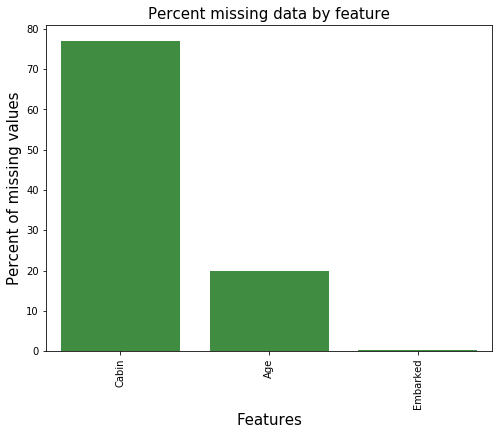

In [3]:
# finding missing data

def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms = pd.concat([total, percent], axis = 1, keys = ['Total','Percent'])
    ms = ms[ms["Percent"] > 0]
    f,ax = plt.subplots(figsize = (8,6))
    plt.xticks(rotation = '90')
    fig = sns.barplot(ms.index, ms["Percent"], color = "green", alpha = 0.8)
    plt.xlabel('Features', fontsize = 15)
    plt.ylabel('Percent of missing values', fontsize = 15)
    plt.title('Percent missing data by feature', fontsize = 15)
    return ms
missingdata(train_df)

The Cabin data has the largest number of missing values among the three features. We need to fix them and this process is called Data Cleaning.


# Data Cleaning

We will fill the missing data with Mode, Mean or Median. For categorized data its mode and for continuous data use mean or median. 
Embarked data -> Mode  and  Age -> median


In [4]:
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace = True)
train_df['Age'].fillna(train_df['Age'].median(), inplace = True)
# For largely missing data like cabin, just remove the data 
drop_column = ['Cabin']
train_df.drop(drop_column, axis = 1, inplace = True)
# check the cleaned data for NaN value
print('Check the NaN value in train data')
print(train_df.isnull().sum()) 

Check the NaN value in train data
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


# Feature Engineering

Embarked data is filled with Q,S or C which can't be processed by python library (only numbers). One Hot Vectorization technique will change the column Embarked into three columns. Let's call them Embarked_Q, Embarked_S and Embarked_C filled with 0 or 1 whether the person embarked from that harbor or not.
The other columns SibSp and Parch will help in determing the passenger's family size. We might asssume that if the family size was bigger, then survival chance would increase, since they could help each other. On the other hand, solo people would've had it hard.
So we create a column, Family Size consisting of sibsp + parch + 1 (passenger themself)
Last technique to be used is called Bin Columns, which creates ranges of values to group several things together. For Age column, we will create 4 bins. Children (0-14yrs), Teenager (14-20), Adult (20-40) and Elder (40+ yrs). For Fare column, Low_Fare (0-7.91), Median_fare (7.91-14.45), Average_Fare (14.45-31) and High_Fare (31=120)

In [5]:
dataset = train_df
dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# import package for using regular expressions
import re
# define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # if title exists, extract and return it
    if title_search:
        return title_search.group(1)
    return ""
# create a new feature Title which contain titles of passenger names
dataset['Title'] =  dataset['Name'].apply(get_title)
# group all non-common titles into single group "Rare"
dataset['Title'] = dataset['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],'Rare')
dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

dataset['Age_bin'] = pd.cut(dataset['Age'], bins=[0,14,20,40,120], labels=['Children','Teenage','Adult','Elder'])

dataset['Fare_bin'] = pd.cut(dataset['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','median_fare', 'Average_fare','high_fare'])

traindf = train_df
drop_column = ['Age','Fare','Name','Ticket']
train_df.drop(drop_column, axis = 1, inplace = True)
drop_column = ['PassengerId']
traindf.drop(drop_column, axis=1, inplace=True)
traindf = pd.get_dummies(traindf, columns=["Sex", "Title", "Age_bin", "Embarked", "Fare_bin"], prefix=["Sex", "Title", "Age_type", "Em_type", "Fare_type"])


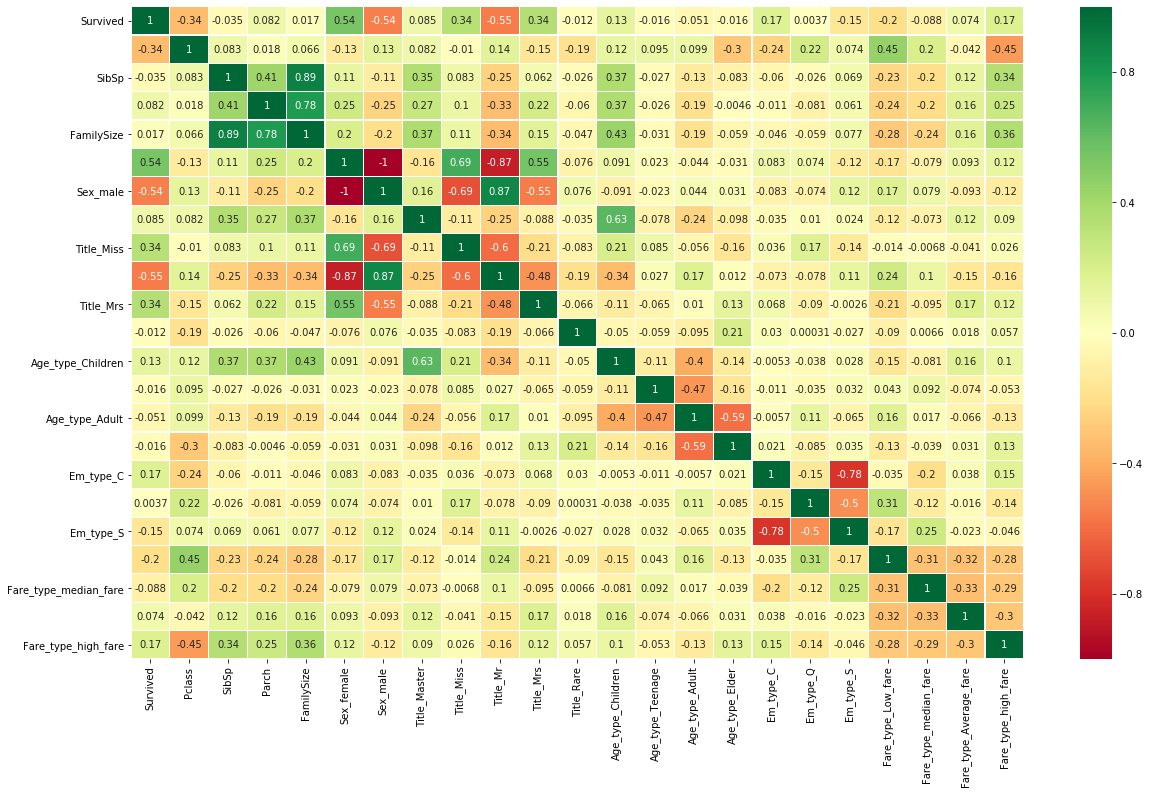

In [6]:
# correlation for each feature
sns.heatmap(traindf.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()


Correlations with value of 1 means highly correlated positively, -1 means highly correlated negatively. For example, sex male and sex female will correlate negatively, since passengers had to identify as one or the other sex. Other than that, you can see that nothing related to anything highly except for the ones created via feature engineering. This means we are good to go.

# Machine Learning Modeling

You can choose many algorithms included inside the scikit-learn library.

Logistic Regression
Random Forest
SVM
K Nearest Neighbor
Naive Bayes
Decision Trees
AdaBoost
LDA
Gradient Boosting

--------------The Accuracy of the model----------------------------
The accuracy of the Random Forest Classifier is 82.09
The cross validated score for Random Forest Classifier is: 83.51
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:   28.1s finished


0.812199036918138


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

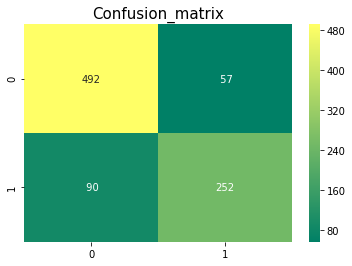

In [15]:
from sklearn.model_selection import train_test_split #for split the data
from sklearn.metrics import accuracy_score  #for accuracy_score
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.metrics import confusion_matrix #for confusion matrix
all_features = traindf.drop("Survived",axis=1)
Targeted_feature = traindf["Survived"]
X_train,X_test,Y_train,Y_test = train_test_split(all_features,Targeted_feature,test_size=0.3,random_state=42)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape


# Random Forest Classifier Algorithm 
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(criterion='gini', n_estimators=700,
                             min_samples_split=10,min_samples_leaf=1,
                             max_features='auto',oob_score=True,
                             random_state=1,n_jobs=-1)
model.fit(X_train,Y_train)
prediction_rm=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Random Forest Classifier is', round(accuracy_score(prediction_rm,Y_test)*100,2))
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
result_rm=cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for Random Forest Classifier is:',round(result_rm.mean()*100,2))
y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)
sns.heatmap(confusion_matrix(Targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix', y=1.05, size=15)


# Random Forest Classifier Parameters Fine Tuning 
model = RandomForestClassifier()
n_estim=range(100,1000,100)

## Search grid for optimal parameters
from sklearn.model_selection import GridSearchCV
param_grid = {"n_estimators" :n_estim}
model_rf = GridSearchCV(model,param_grid = param_grid, cv=5, scoring="accuracy", n_jobs= 4, verbose = 1)
model_rf.fit(X_train,Y_train)

# Best score
print(model_rf.best_score_)

#best estimator
model_rf.best_estimator_